In [19]:
# libraries
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import random
import cv2
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import keras
import tensorflow as tf

from keras import models, layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
images_path = '/kaggle/input/sign-language/KSL-dataset/Images'
test_path = '/kaggle/input/sign-language/KSL-dataset/Test.csv'
train_path = '/kaggle/input/sign-language/KSL-dataset/Train.csv'

# **Exploratory analysis of training dataset**
## 1.**Train data**

In [21]:
train_df = pd.read_csv(train_path)
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [22]:
# different classes of images

train_df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [23]:
train_df.shape

(6249, 2)

> Training images constitutes of 6,294 images  with 9 different classes.

**Sample images**

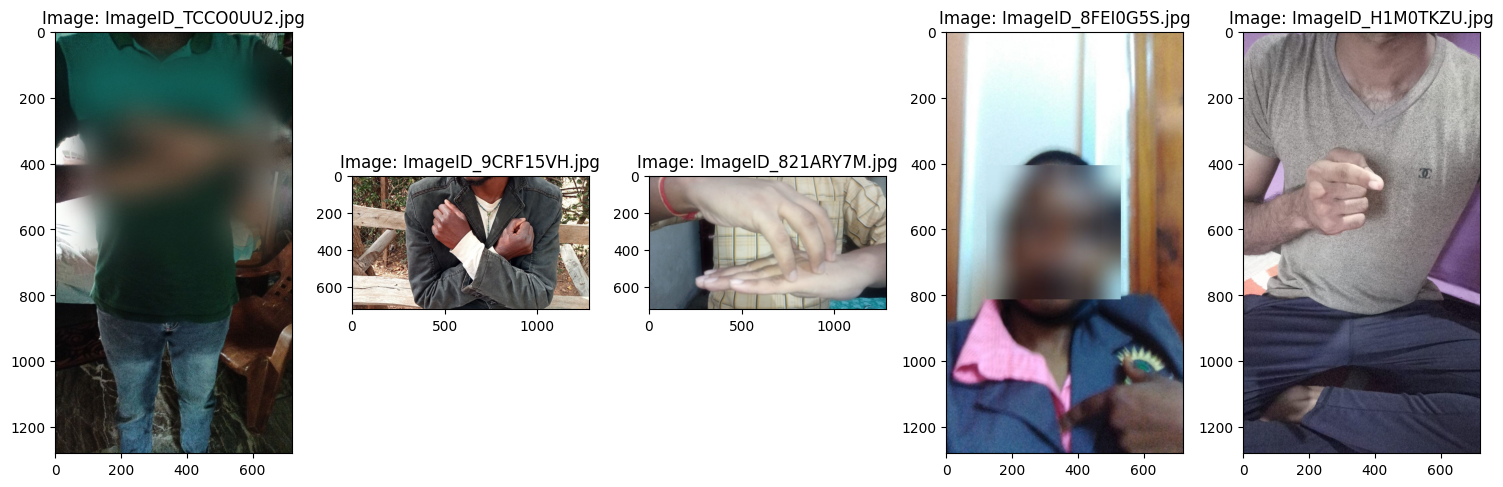

In [24]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
random_images = random.sample(images, 5)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('on')
plt.tight_layout()
plt.show()

From the sample visulization, all the images bearing different sign languages have varying sizes. Some images are larger widths or heights than the others.

**Image mapping to corresponding labels**

In [77]:
from tensorflow.keras.optimizers import Adam
class KSL:
    def __init__(self, imgs_path, df, LR = 1e-3, IMG_SIZE = 256, BATCH_SIZE = 32):
        self.imgs_path = imgs_path
        self.df = df
        self.LR = LR
        self.IMG_SIZE = IMG_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        
    def create_mapping(self):
        # Mapping image ids, their paths, and labels together - All images are .jpg format
        self.df['img_path'] = self.df['img_IDS'].apply(lambda x: 
                                                os.path.join(self.imgs_path, f"{x}.jpg"))
        class_mapping = {label: idx for idx, label in enumerate(self.df['Label'].unique())}
        self.df['Encoded_Label'] = self.df['Label'].map(class_mapping)
        return self.df
 

    def crop_center(self, image, crop_size=(600, 600),  target_size=(256, 256)):
        h, w, _ = image.shape
        crop_h, crop_w = crop_size

        start_x = (w - crop_w) // 2
        start_y = (h - crop_h) // 2

        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        
        resized_image = cv2.resize(cropped_image, target_size)
        return resized_image
    
    def plot_images_with_labels(self, num_images=5, crop_size=(600, 600),  target_size=(256, 256)):
        df = self.create_mapping()
        plt.figure(figsize=(15, 10))
        sample_df = df.sample(num_images)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            # Load the image
            img_path = row['img_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            resized_img = self.crop_center(img, crop_size=crop_size,target_size = target_size )
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(resized_img)
            plt.title(row["Label"])
            plt.axis('on')
        plt.tight_layout()
        plt.show()
        
    def process_ksl_images(self):
        df = self.create_mapping()
        
        def preprocessing_function(img):
            return self.crop_center(img, crop_size=(600, 600), target_size=(self.IMG_SIZE, self.IMG_SIZE))
        
        datagen=ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.25,
                                   preprocessing_function=preprocessing_function
                                  )
        train_images=datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE,self.IMG_SIZE))
        validation_images=datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="validation",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE,self.IMG_SIZE))
        training_steps=train_images.n//train_images.batch_size
        validation_steps=validation_images.n//validation_images.batch_size
        return train_images, validation_images, training_steps, validation_steps
        
    def ksl_model(self):
        model = Sequential()
        # Our images interesting section varies from image to image, 
        # so we use image of 1024 x 1024 maximum dimensions.
        model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                         activation ='relu', input_shape = (self.IMG_SIZE,self.IMG_SIZE,3)))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(0.5))
        model.add(Dense(9, activation = "softmax"))
        
        optimizer = Adam(learning_rate=self.LR)
        
        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [78]:
ksl = KSL(imgs_path=images_path, df=train_df)
df = ksl.create_mapping()

In [79]:
df.head()

,img_IDS,Label,img_path,Encoded_Label
0,ImageID_33HMDMJ3,Temple,/kaggle/input/sign-language/KSL-dataset/Images...,0
1,ImageID_V5POEX4O,Church,/kaggle/input/sign-language/KSL-dataset/Images...,1
2,ImageID_89CCCCW6,Enough/Satisfied,/kaggle/input/sign-language/KSL-dataset/Images...,2
3,ImageID_GNJXOWX5,Me,/kaggle/input/sign-language/KSL-dataset/Images...,3
4,ImageID_7Q9LOP7R,Love,/kaggle/input/sign-language/KSL-dataset/Images...,4


In [80]:
df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [81]:
df.shape

(6249, 4)

In [82]:
df.head()

,img_IDS,Label,img_path,Encoded_Label
0,ImageID_33HMDMJ3,Temple,/kaggle/input/sign-language/KSL-dataset/Images...,0
1,ImageID_V5POEX4O,Church,/kaggle/input/sign-language/KSL-dataset/Images...,1
2,ImageID_89CCCCW6,Enough/Satisfied,/kaggle/input/sign-language/KSL-dataset/Images...,2
3,ImageID_GNJXOWX5,Me,/kaggle/input/sign-language/KSL-dataset/Images...,3
4,ImageID_7Q9LOP7R,Love,/kaggle/input/sign-language/KSL-dataset/Images...,4


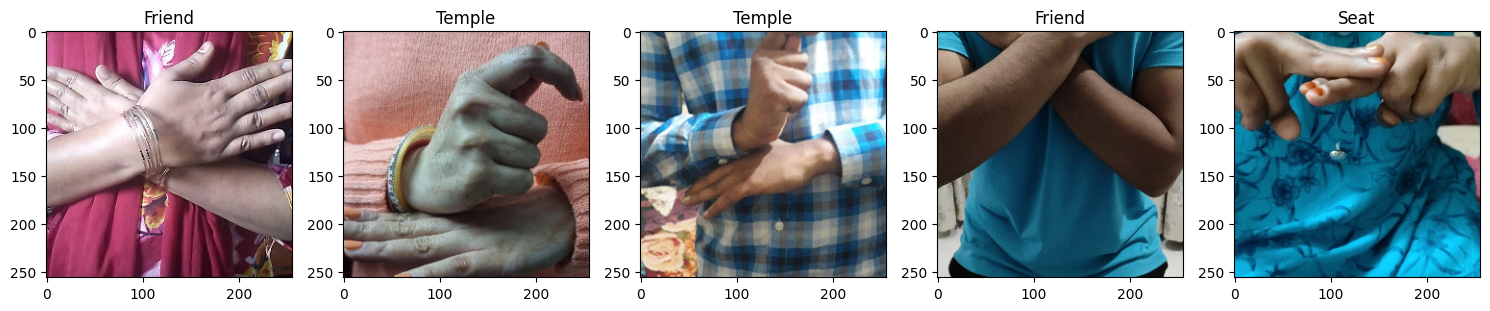

In [83]:
ksl.plot_images_with_labels()

In [84]:
ksl.ksl_model()

<Sequential name=sequential_10, built=True>

In [85]:
model = ksl.ksl_model()
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 256, 256, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,781,561 (64.02 MB)

 Trainable params: 16,781,561 (64.02 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
train_images, validation_images, training_steps, validation_steps = ksl.process_ksl_images()

Found 4687 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.


In [87]:
print(f"Training steps:{training_steps}")
print(f"Validation steps: {validation_steps}")

Training steps:146
Validation steps: 48


In [88]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(train_images,
                    steps_per_epoch=training_steps,
                    validation_data=validation_images,
                    validation_steps=validation_steps,
                    epochs=5,
                    callbacks =[reduce_lr]
                    )


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.1126 - loss: 3.6798 - val_accuracy: 0.1185 - val_loss: 2.2914 - learning_rate: 0.0010
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1250 - loss: 2.2059 - val_accuracy: 0.1154 - val_loss: 2.5900 - learning_rate: 0.0010
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.1310 - loss: 2.1911 - val_accuracy: 0.1589 - val_loss: 2.2512 - learning_rate: 0.0010
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.0938 - loss: 2.2150 - val_accuracy: 0.1154 - val_loss: 2.4135 - learning_rate: 0.0010
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.1575 - loss: 2.1500 - val_accuracy: 0.1992 - val_loss: 2.2124 - learning_rate: 0.0010
